In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from infomap import Infomap
import networkx as nx
import numpy as np

# load csv
csv_path = "drymesaclasstime.csv" 
df = pd.read_csv(csv_path)

# map node names to int
unique_nodes = pd.unique(df[['from', 'to']].values.ravel())
node_map = {name: i for i, name in enumerate(unique_nodes)}
reverse_node_map = {i: name for name, i in node_map.items()}

# build network with infomap
im = Infomap("--two-level --markov-time 1 --preferred-number-of-modules 7")

for _, row in df.iterrows():
    u = node_map[row["from"]]
    v = node_map[row["to"]]
    weight = float(row["weight"])
    im.add_link(u, v, weight)

im.run()

# id modules
modules = {node.node_id: node.module_id for node in im.nodes}
name_modules = {reverse_node_map[node_id]: mod for node_id, mod in modules.items()}

# sort data for plotting
zone_order = sorted(df['time'].unique())
zone_map = {zone: i + 1 for i, zone in enumerate(zone_order)}

node_modules = []
for name in unique_nodes:
    time = df[df['from'] == name]['time'].values
    if len(time) == 0:
        time = df[df['to'] == name]['time'].values
    time = time[0] if len(time) > 0 else "Zone 0"
    module = name_modules[name]
    node_modules.append((name, module, zone_map.get(time, 0)))

plot_df = pd.DataFrame(node_modules, columns=["node", "module", "zone"])

# make networkx graph
G = nx.Graph()
for _, row in df.iterrows():
    u = node_map[row["from"]]
    v = node_map[row["to"]]
    G.add_edge(u, v, weight=row["weight"])

# Assign module as a node attribute
nx.set_node_attributes(G, modules, "module")

  Infomap v2.8.0 starts at 2025-04-28 17:36:27
  -> Input network: 
  -> No file output!
  -> Configuration: two-level
                    markov-time = 1
                    preferred-number-of-modules = 7
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 43 nodes and 154 links...
  -> One-level codelength: 5.00889678

Trial 1/1 starting at 2025-04-28 17:36:27
Two-level compression: -9.2% 0.73% 
Partitioned to codelength 0.868150497 + 4.82714038 + 0 = 5.695290877 in 7 (3 non-trivial) modules.

=> Trial 1/1 finished in 0.000203708s with codelength 5.69529088


Summary after 1 trial
Best end modular solution in 2 levels (warning: worse than one-level solution):
Per level number of modules:         [          7,           0] (sum: 7)
Per level number of leaf nodes:      [          0,          43]

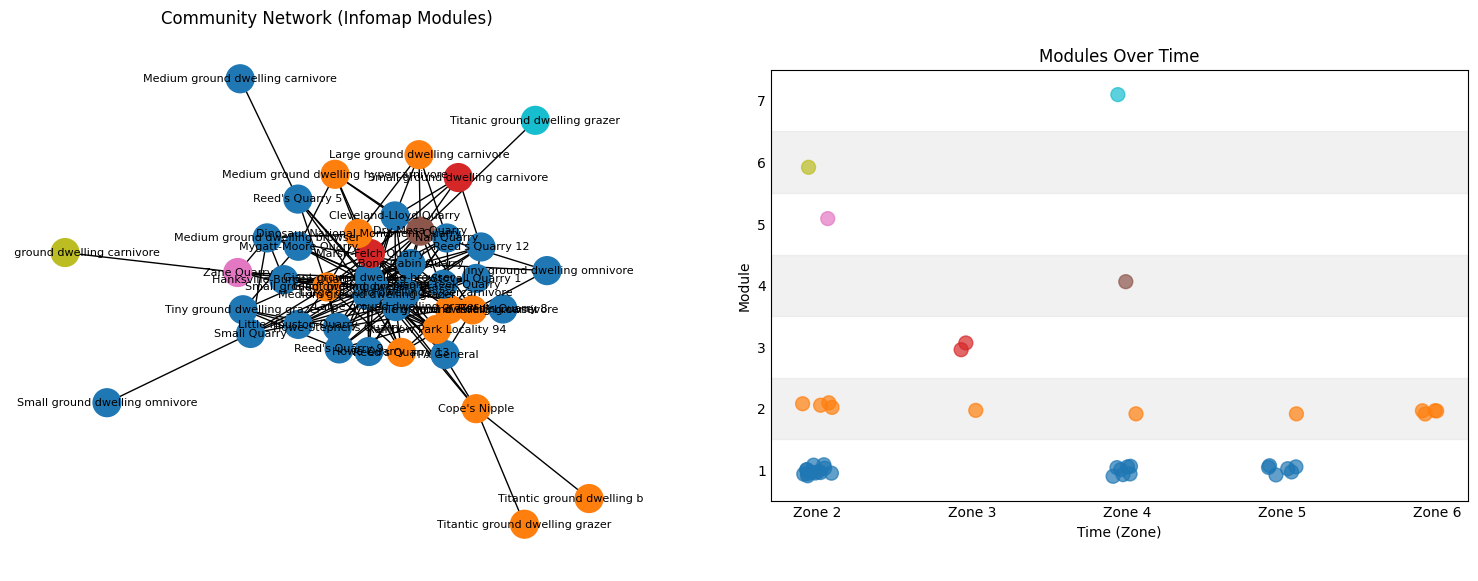

In [23]:

# plot network and stepped scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# network plot
pos = nx.spring_layout(G, seed=42)
node_colors = [modules[n] for n in G.nodes()]
nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=400, with_labels=False, ax=ax1)
nx.draw_networkx_labels(G, pos, labels={node_map[name]: name for name in unique_nodes}, font_size=8, ax=ax1)
ax1.set_title("Community Network (Infomap Modules)")

# stepped plot

# Add jitter
np.random.seed(42)
jitter1 = np.random.uniform(-0.1, 0.1, size=len(plot_df))
jitter2 = np.random.uniform(-0.1, 0.1, size=len(plot_df))
plot_df["zone_jitter"] = plot_df["zone"] + jitter1
plot_df["module_jitter"] = plot_df["module"] + jitter2

# make the plot
module_ids = sorted(plot_df["module"].unique())
for module_id in module_ids:
    if module_id % 2 == 0:
        ax2.axhspan(module_id - 0.5, module_id + 0.5, color="lightgrey", alpha=0.3)

scatter = ax2.scatter(
    plot_df["zone_jitter"], plot_df["module_jitter"],
    s=100, c=plot_df["module"], cmap="tab10", alpha=0.7
)

ax2.set_xlabel("Time (Zone)")
ax2.set_ylabel("Module")
ax2.set_title("Modules Over Time")

# Set x-ticks and labels
ax2.set_xticks(list(zone_map.values()))
ax2.set_xticklabels(list(zone_map.keys()))

# Set y-ticks at integer module IDs
ax2.set_yticks(module_ids)

# remove tick marks keep labels
ax2.tick_params(axis='both', which='both', length=0)
#set ylim
ax2.set_ylim(min(module_ids) - 0.5, max(module_ids) + 0.5)

# Remove gridlines
ax2.grid(False)

box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + 0.1, box.width * 1.1, box.height * 0.8])

plt.show()

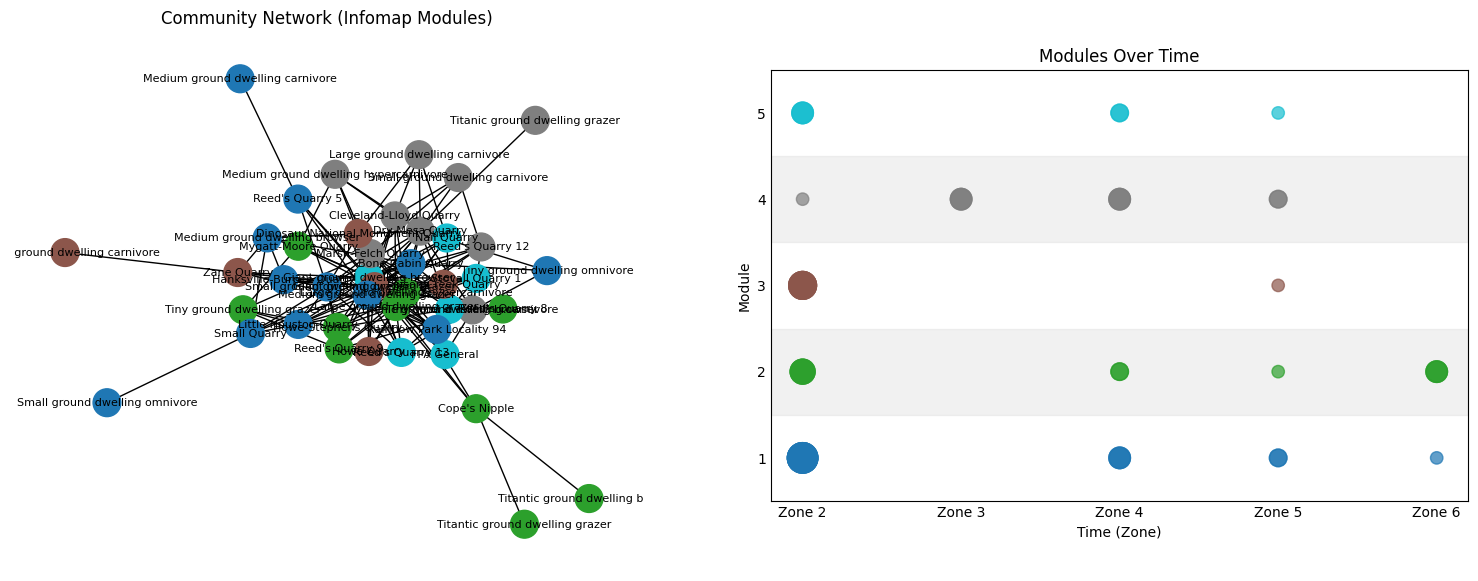

In [3]:

# plot network and stepped scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# network plot
pos = nx.spring_layout(G, seed=42)
node_colors = [modules[n] for n in G.nodes()]
nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=400, with_labels=False, ax=ax1)
nx.draw_networkx_labels(G, pos, labels={node_map[name]: name for name in unique_nodes}, font_size=8, ax=ax1)
ax1.set_title("Community Network (Infomap Modules)")

# stepped plot

# Calculate the number of nodes for each (zone, module) pair
size_data = plot_df.groupby(["zone", "module"]).size().reset_index(name='node_count')

# Merge this data back into the plot dataframe
plot_df = plot_df.merge(size_data, on=["zone", "module"])

# make the plot
mmodule_ids = sorted(plot_df["module"].unique())
for module_id in module_ids:
    if module_id % 2 == 0:
        ax2.axhspan(module_id - 0.5, module_id + 0.5, color="lightgrey", alpha=0.3)

scatter = ax2.scatter(
    plot_df["zone"], plot_df["module"],
    s=plot_df["node_count"] * 80,  
    c=plot_df["module"], cmap="tab10", alpha=0.7
)

ax2.set_xlabel("Time (Zone)")
ax2.set_ylabel("Module")
ax2.set_title("Modules Over Time")

# Set x-ticks and labels
ax2.set_xticks(list(zone_map.values()))
ax2.set_xticklabels(list(zone_map.keys()))

# Set y-ticks at integer module IDs
ax2.set_yticks(mmodule_ids)

# remove tick marks keep labels
ax2.tick_params(axis='both', which='both', length=0)

# set ylim
ax2.set_ylim(min(mmodule_ids) - 0.5, max(mmodule_ids) + 0.5)

# Remove gridlines
ax2.grid(False)

# Adjust plot layout
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + 0.1, box.width * 1.1, box.height * 0.8])

plt.show()

In [ ]:
df2 = df

# load csv
csv_path = "drymesahighsize.csv" 
df = pd.read_csv(csv_path)

zone_dict = dict(zip(df2['from'], df2['time']))
# add column to df called time which uses the zone_dict to map the from column to the time column
df['time'] = df['from'].map(zone_dict)
# make unmapped values Zone 0
df['time'] = df['time'].fillna('Zone 0')
df.to_csv("drymesahighsize.csv", index=False)

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
from infomap import Infomap
import networkx as nx
import numpy as np

# load csv
csv_path = "drymesahighsize.csv" 
df = pd.read_csv(csv_path)

# map node names to int
unique_nodes = pd.unique(df[['from', 'to']].values.ravel())
node_map = {name: i for i, name in enumerate(unique_nodes)}
reverse_node_map = {i: name for name, i in node_map.items()}

# build network with infomap
im = Infomap("--two-level --markov-time 0.3 --preferred-number-of-modules 5")

for _, row in df.iterrows():
    u = node_map[row["from"]]
    v = node_map[row["to"]]
    weight = float(row["weight"])
    im.add_link(u, v, weight)

im.run()

# id modules
modules = {node.node_id: node.module_id for node in im.nodes}
name_modules = {reverse_node_map[node_id]: mod for node_id, mod in modules.items()}

# sort data for plotting
zone_order = sorted(df['time'].unique())
zone_map = {zone: i + 1 for i, zone in enumerate(zone_order)}

node_modules = []
for name in unique_nodes:
    time = df[df['from'] == name]['time'].values
    if len(time) == 0:
        time = df[df['to'] == name]['time'].values
    time = time[0] if len(time) > 0 else "Zone 0"
    module = name_modules[name]
    node_modules.append((name, module, zone_map.get(time, 0)))

plot_df = pd.DataFrame(node_modules, columns=["node", "module", "zone"])

# make networkx graph
G = nx.Graph()
for _, row in df.iterrows():
    u = node_map[row["from"]]
    v = node_map[row["to"]]
    G.add_edge(u, v, weight=row["weight"])

# Assign module as a node attribute
nx.set_node_attributes(G, modules, "module")

  Infomap v2.8.0 starts at 2025-04-28 10:52:58
  -> Input network: 
  -> No file output!
  -> Configuration: two-level
                    markov-time = 0.3
                    preferred-number-of-modules = 5
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 51 nodes and 151 links...
  -> Rescale link flow with global Markov time 0.3
  -> One-level codelength: 5.1655356

Trial 1/1 starting at 2025-04-28 10:52:58
Two-level compression: -1.8% 24% 
Partitioned to codelength 0.404374636 + 3.56544151 + 0 = 3.969816142 in 5 modules.

=> Trial 1/1 finished in 0.000305708s with codelength 3.96981614


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,          51] (sum: 

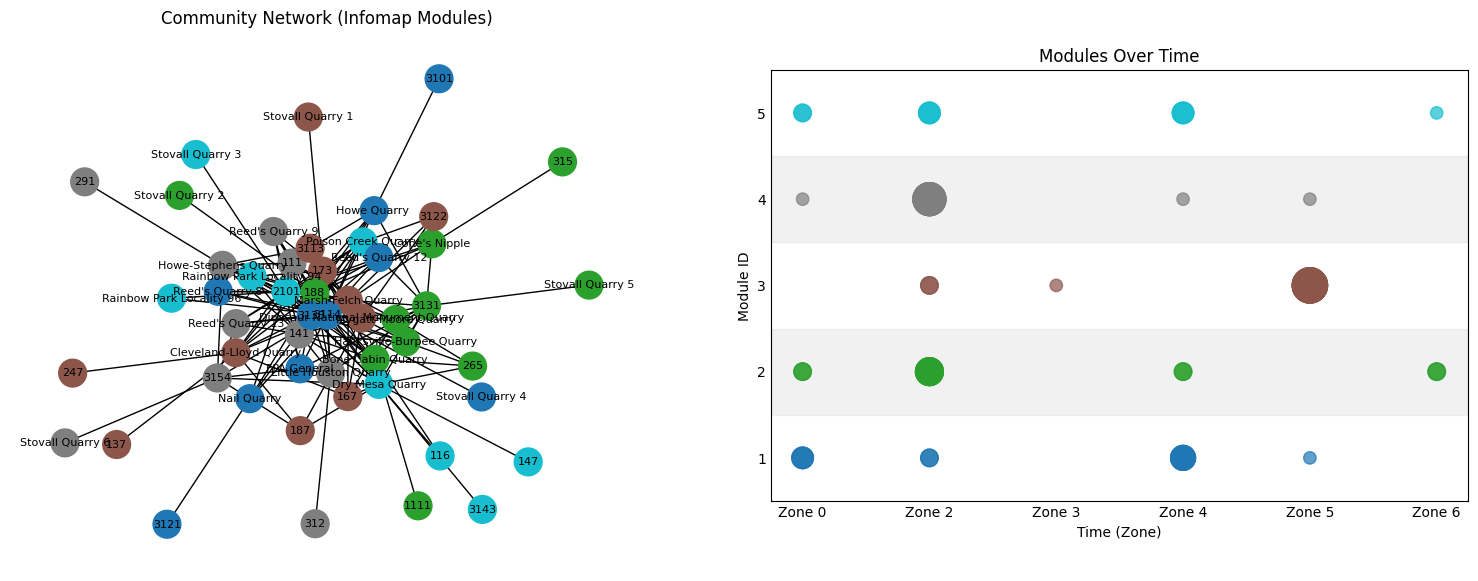

In [ ]:

# plot network and stepped scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# network plot
pos = nx.spring_layout(G, seed=42)
node_colors = [modules[n] for n in G.nodes()]
nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=400, with_labels=False, ax=ax1)
nx.draw_networkx_labels(G, pos, labels={node_map[name]: name for name in unique_nodes}, font_size=8, ax=ax1)
ax1.set_title("Community Network (Infomap Modules)")

# stepped plot

# Calculate the number of nodes for each (zone, module) pair
size_data = plot_df.groupby(["zone", "module"]).size().reset_index(name='node_count')

# Merge this data back into the plot dataframe
plot_df = plot_df.merge(size_data, on=["zone", "module"])

# make the plot
mmodule_ids = sorted(plot_df["module"].unique())
for module_id in module_ids:
    if module_id % 2 == 0:
        ax2.axhspan(module_id - 0.5, module_id + 0.5, color="lightgrey", alpha=0.3)

scatter = ax2.scatter(
    plot_df["zone"], plot_df["module"],
    s=plot_df["node_count"] * 80,  
    c=plot_df["module"], cmap="tab10", alpha=0.7
)

ax2.set_xlabel("Time (Zone)")
ax2.set_ylabel("Module")
ax2.set_title("Modules Over Time")

# Set x-ticks and labels
ax2.set_xticks(list(zone_map.values()))
ax2.set_xticklabels(list(zone_map.keys()))

# Set y-ticks at integer module IDs
ax2.set_yticks(mmodule_ids)

# remove tick marks keep labels
ax2.tick_params(axis='both', which='both', length=0)

# set ylim
ax2.set_ylim(min(mmodule_ids) - 0.5, max(mmodule_ids) + 0.5)

# Remove gridlines
ax2.grid(False)

# Adjust plot layout
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + 0.1, box.width * 1.1, box.height * 0.8])

plt.show()